# Hello TensorFlow

## Digit classification

The very first tutorial on the Tensorflow site, showing how to learn the MNIST data set.

These data are hand written images of digits that are 28x28 pixels in size that are also perfectly centered. From a Bayesian perspective, the data are generated as independent draws from a categorical (Multinoulli) distribution, with no possibility of draws being from many categories (i.e. a sample will not have more than one class; the classes are all mutually exclusive). For this reason, the likelihood of an individual sample is
$$
\mathcal{L}(x|\theta) = \sum_{i=0}^S \delta_{c(x),i}p(i|x,\theta)\,,
$$
where $\theta$ represents the latent variables in our model (i.e. the network weights), $p(i|x,\theta)$ is the probability that the current sample is equal to digit $i$, and $\delta_{c(x),i}$ is a delta function that is 1 when the sample's class ($c(x)$) is equal to $i$ and 0 otherwise. This way, the total likelihood of all the samples is given by the product of all the likelihoods
$$
\mathcal{L}({\rm x}|\theta)= \prod_{j=1}^{N_{\rm samples}}\mathcal{L}(x_j|\theta) = \prod_{j=1}^{N_{\rm samples}} \sum_{i=0}^S \delta_{c(x_j),i}p(i|x_j,\theta)\,,
$$
where we can write the set of all samples as ${\rm x}=\{x_j\}_{j=1}^{N_{\rm samples}}$.

In this notebook, we use the same network layout as suggested in the [tutorial page](https://www.tensorflow.org/overview/) on TensorFlow's website. In this instance, each digit is first flattened into a vector (1D array), goes through a dense rectifier, then has random dropout, and finally a softmax layer to renormalize everything into classification. In equation form, this means that for the first layer the output is given as
$$
{\rm y} = [y_0, y_1, ..., y_m]^T; y_i = (W_1{\rm x})_i^+\,,
$$
and $W_1$ is the $m \times n$ weight matrix. $n$ is the number of pixels in the images, and $m$ is the size of the output (we choose 128). Next is random dropout with a rate $r=0.2$
$$
\tilde{\rm y} = {\rm Dropout}({\rm y}, r)
$$
we then go to a softmax layer for classification:
$$
{\rm z} = [z_0, z_1, ... z_S]^T; z_i = \frac{\exp(W_2 \tilde{\rm y})_i}{\sum_{j=0}^S \exp(W_2 \tilde{\rm y})_j}\,.
$$
To clarify, the latent variables include the weights $\theta = \{W_1,W_2\}$.

Given a nice closed form for the likelihood, it makes sense to use the cross-entropy (negative log likelihood) as the loss function:
$$
{\rm Loss} = -\ln\mathcal{L}({\rm x})\,.
$$

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Probabilistic Graphical Model

We can visualize this whole process using a probabilistic graphical model (PGM). This particular type of graph will show an acyclical graph that represents how we believe the labels of the data were generated (i.e. via our model -- a surrogate for how the real world works). To make this figure I use the handy dandy package called [daft](https://github.com/daft-dev/daft).

In [19]:
import daft

plt.rc("font", family="serif", size=12)
plt.rc("text", usetex=True)

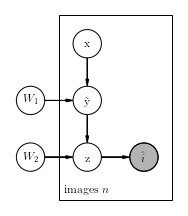

In [29]:
pgm = daft.PGM()

pgm.add_node("W1", r"$W_1$", -1, 1)
pgm.add_node("W2", r"$W_2$", -1, 0)
pgm.add_node("x", r"${\rm x}$", 0, 2)
pgm.add_node("yt", r"$\tilde{\rm y}$", 0, 1)
pgm.add_node("z", r"${\rm z}$", 0, 0)
pgm.add_node("id", r"$\hat{i}$", 1, 0, observed=True)
pgm.add_edge("x", "yt")
pgm.add_edge("W1", "yt")
pgm.add_edge("yt", "z")
pgm.add_edge("W2", "z")
pgm.add_edge("z", "id")
pgm.add_plate([-0.5, -0.75, 2, 3.25], label=r"images $n$")
pgm.render()

In [2]:
#Load the data set and pull out the test/train split
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255., x_test/255.

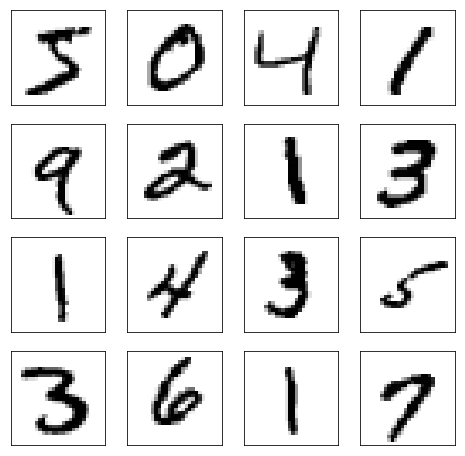

In [3]:
#Look at some of the training images
plt.figure(figsize=(8,8))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
plt.show()

In [4]:
#Create the model network
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [5]:
#Compile the model
model.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [6]:
model.fit(x_train, y_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 62us/sample - loss: 0.2933 - accuracy: 0.9146
Epoch 2/5
60000/60000 [==============================] - 3s 49us/sample - loss: 0.1400 - accuracy: 0.9581
Epoch 3/5
60000/60000 [==============================] - 3s 47us/sample - loss: 0.1046 - accuracy: 0.9688
Epoch 4/5
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0873 - accuracy: 0.9726
Epoch 5/5
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0758 - accuracy: 0.9762


In [7]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

10000/1 - 0s - loss: 0.0416 - accuracy: 0.9750

Test accuracy: 0.975


(784, 128)


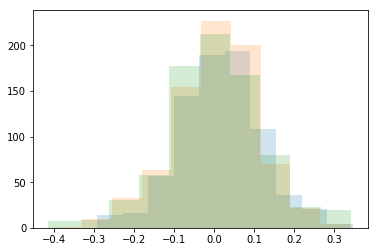

In [8]:
W = model.layers[1].variables[0].numpy()
print(W.shape)
for i in range(3):
    plt.hist(W[:,i], alpha=0.2)

In [9]:
class_names = np.arange(10)
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [12]:
predictions = model.predict(x_test)

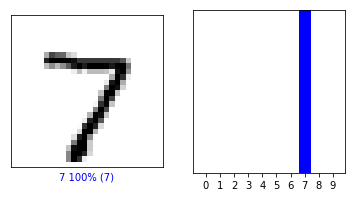

In [16]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], y_test, x_test)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  y_test)

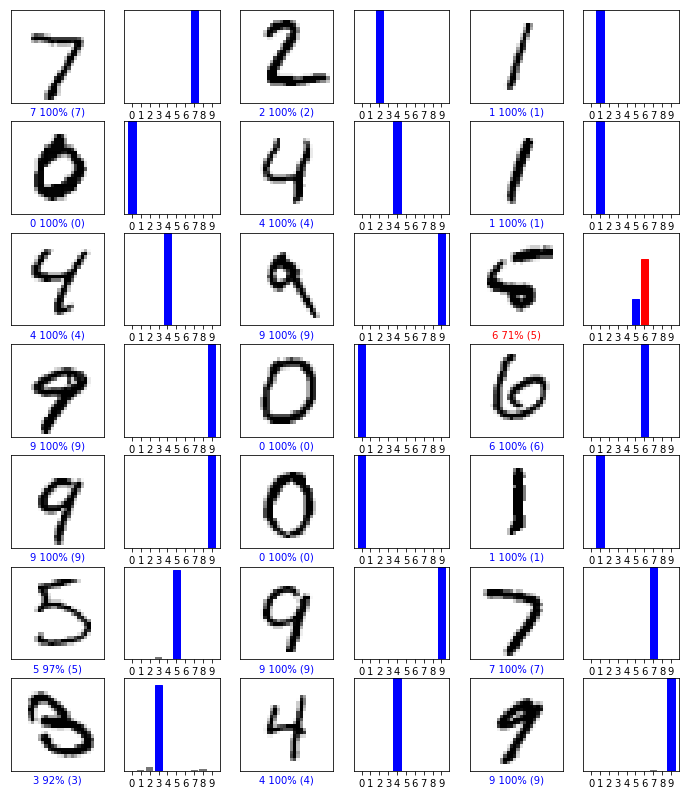

In [18]:
#Look at some of the training images
nrows = 7
ncols = 3
nimages = nrows*ncols
plt.figure(figsize=(2*2*ncols,2*nrows))
for i in range(nimages):
    plt.subplot(nrows, 2*ncols, 2*i+1)
    plot_image(i, predictions[i], y_test, x_test)
    plt.subplot(nrows, 2*ncols, 2*i+2)
    plot_value_array(i, predictions[i],  y_test)